In [1]:
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower')
import numpy as np
from onset_detection import detected_samples
import matplotlib.pyplot as plt
import helper
import scipy.io.wavfile as wav
from datetime import datetime
import least_squares

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece



/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models/least_squares.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(wav_file)


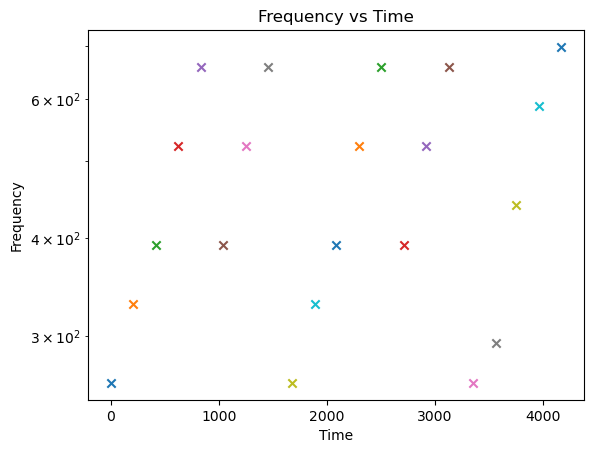

540


In [3]:
notes = process_midi_to_note_info(
    '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Prelude1.midi')
chords = notes_to_chords(notes, sustain=False)

plot_piece(chords, 20)
plt.show()
score, next = dict_to_frequency_list(chords)
print(len(next))


In [18]:
hop = 500
sample_len = 1000
cov_dict = {}
offset = 3000


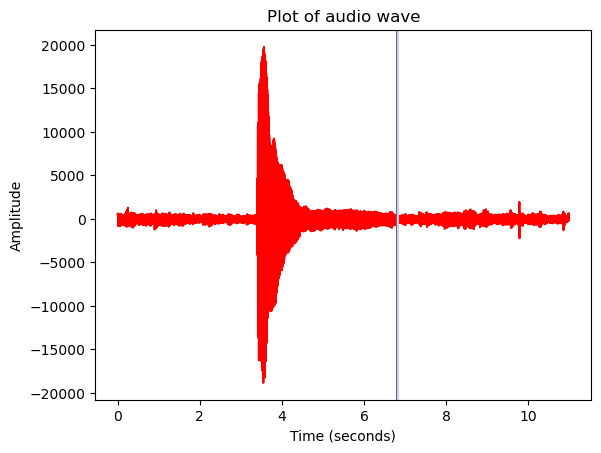

In [64]:
path =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/initial_noise.wav'
sample_rate, data = wav.read(path)

audio_duration = len(data)/sample_rate
frames = [ data[1000:1000+1000], data[2000:2000+1000], data[30000:30000+1000], data[60000:60000+1000], data[80000:80000+1000], data[170000:171000],data[300000:301000]]


time_samples = np.linspace(0, audio_duration, len(data))
# sample_indices = np.arange(0, len(data), hop)
# sample_data = [data[offset + index:index+sample_len + offset] for index in sample_indices]
helper.plot_audio(time_samples, data)

plt.axvline(300000/sample_rate)
plt.axvline(300000/sample_rate + sample_len/sample_rate, color = 'pink')

In [81]:
print(np.sum(np.abs(frames[0])))
print(np.sum(np.abs(frames[1])))
print(np.sum(np.abs(frames[-2])))

436111
429710
4666199


[-42329785753.87223, -457026442.52791286, -175072015.78792065, -118285872.64855178, -81129688.03625423, -68251950.6563416, -60948115.63104841, -61497084.92771178, -211023025.00410634, -799186435.6642885, -3122322980.923984, -19359065473.094776, -158464130985.90674, -409307217254.1471, -709041234820.0846, -795308703532.9781, -802674214265.7845, -913422296136.6249, -979500695681.022, -996915237692.0433, -989767650738.3276, -999749437903.0538, -1034923320902.434, -1041684558940.5728, -1040043355147.9738, -1039524472694.1487, -1061912003601.3794, -1068460227921.5825, -1069511496625.9302, -1067867707773.0056, -1077025994597.2234, -1081253863565.7623, -1082413969593.7308, -1081637453412.6285, -1083763584336.1384, -1089097394217.6605, -1090056553523.4948, -1089685109260.5316, -1089834607654.9296, -1094231428142.568, -1095150905553.7937, -1095070134795.9347, -1094938492278.6495, -1097690227138.9434, -1098396355533.7584, -1098431782088.8557, -1098272063018.4869, -1099650714940.798, -11009716771

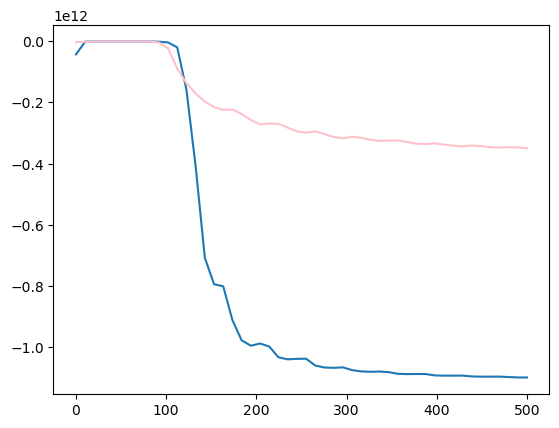

In [80]:

time_samples = np.linspace(0, len(frames[0])/44100, len(frames[0]))


# helper.plot_audio(time_samples, frames[-2])
# print(-helper.stable_nlml(time_samples, frames[0], f=[440], normalised=False))
# print(-helper.stable_nlml(time_samples, frames[-1], f=[440], normalised=False))
# print(-helper.stable_nlml(time_samples, frames[-2], f=[440], normalised=False))
freqs = np.linspace(0, 500, 50)
probs = []
probs1 = []
for f in freqs:
    probs.append(-helper.stable_nlml(time_samples, frames[1], f=[f], normalised=False))
    probs1.append(-helper.stable_nlml(time_samples, frames[-1], f=[f], normalised=False))

print(probs)

import matplotlib.pyplot as plt

plt.plot(freqs, probs)
plt.plot(freqs, probs1, color='pink')

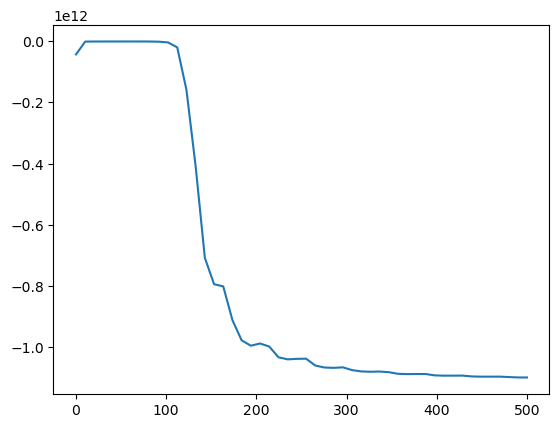

In [77]:
plt.plot(freqs, probs)

In [540]:
def oltw(sample_data: list, score: list, time_samples: np.ndarray, n: int, pedal: bool = False, cov_dict:dict=None,back_track: int=0):
    state_number, audio_frame_number = 0, 0
    path = []
    for sample in sample_data[:-n]:
        ml = 0
        if np.sum(abs(sample))>10:
            lml = []
            num_lookahead = min(len(score) - state_number + 1, n) + back_track
            print(state_number, audio_frame_number)
            score_states = []
            for i in range(num_lookahead):
                score_states.append(max(state_number+i-back_track, 0))
                lml.append(-helper.stable_nlml(time_samples=time_samples, Y=sample, T=0.465, v=2.37, M=9,sigma_f=0.1, cov_dict=cov_dict, normalised=False,f=score[max(state_number+i-back_track, 0)]))
            print(score_states)
            print(lml)

            
            # priors = 1/np.arange(1, num_lookahead+1)
            priors = [0.98,0.99,1,0.99,0.98,0.97]#np.ones(num_lookahead)
            lml =np.array(lml)
            normalised_lml = lml/np.sum(abs(lml)) # Normalise to 1 so that we can feasibly compute the ml (e^lml)
            posterior_ml = np.exp(normalised_lml) * priors

            index = np.argmax(posterior_ml)
            ml = posterior_ml[index]

            state_number += index - back_track
        
        else:
            print("skipped the audio")
            
        path.append((state_number, audio_frame_number, ml))
        audio_frame_number += 1
        
    return path


In [541]:
sample_time_samples = np.linspace(0, sample_len/sample_rate, len(sample_data[0]))

for state in score[:250]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            sample_time_samples, sample_time_samples, M=9,  f=state, sigma_f=0.1, T=0.465, v=2.37) + 0.01**2 * np.eye(sample_len)

# path = oltw(sample_data[:30], score, sample_time_samples, 3)

In [542]:
path = oltw(sample_data[:80], score, sample_time_samples, n=4, cov_dict=cov_dict, back_track=2)

0 0
[0, 0, 0, 1, 2, 3]
[-6764414779.419428, -6764414779.419428, -6764414779.419428, -6848254814.662904, -6679609585.543753, -6984394041.969288]
0 1
[0, 0, 0, 1, 2, 3]
[-4129760454178.817, -4129760454178.817, -4129760454178.817, -8041963276918.796, -6909406689849.606, -8031051691436.64]
0 2
[0, 0, 0, 1, 2, 3]
[-72398041006680.33, -72398041006680.33, -72398041006680.33, -74911521656783.0, -1943955213009.4175, -77328543422988.75]
2 3
[0, 1, 2, 3, 4, 5]
[-159149755736.001, -6619959850778.34, -6313540158298.902, -158656614237.26062, -6715714658402.064, -6313540158298.902]
3 4
[1, 2, 3, 4, 5, 6]
[-223263075304370.62, -2323857460861.2354, -231731905154324.34, -238185402279829.97, -2323857460861.2354, -231731905154324.34]
2 5
[0, 1, 2, 3, 4, 5]
[-258843166847.1703, -11484945313640.623, -11214701969349.605, -289402403671.38007, -11654151175217.895, -11214701969349.605]
3 6
[1, 2, 3, 4, 5, 6]
[-94548654942258.48, -72122276013145.42, -79070322310057.14, -99003338106525.16, -72122276013145.42, -79

In [516]:
print(-helper.stable_nlml(time_samples=sample_time_samples, Y=sample_data[8], T=0.465, v=2.37, M=9,sigma_f=0.1, cov_dict=cov_dict, normalised=False,f=score[3]))
print(-helper.stable_nlml(time_samples=sample_time_samples, Y=sample_data[8], T=0.465, v=2.37, M=9,sigma_f=0.1, cov_dict=cov_dict, normalised=False,f=score[0]))

-24132447244178.117
-22134603045693.598


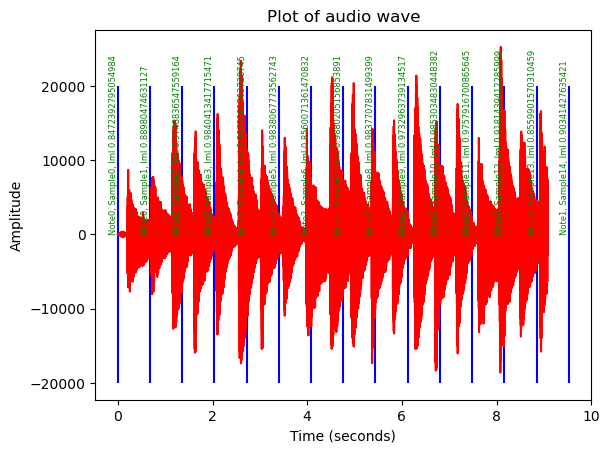

In [548]:
link =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(link)
data=data[:400000]
audio_duration = len(data)/sample_rate
time_samples = np.linspace(0, audio_duration, len(data))
helper.plot_audio(time_samples, data)

for i in range(len(sample_indices[:15])):
    plt.vlines(sample_indices[i]/sample_rate, ymin=-
                       20000, ymax=20000, colors='blue', zorder=2)
    note = path[i][0]
    sample = path[i][1]
    lml = path[i][2]
    plt.text(sample_indices[i]/sample_rate, 0.3, f'Note{note}, Sample{sample}, lml {lml}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    

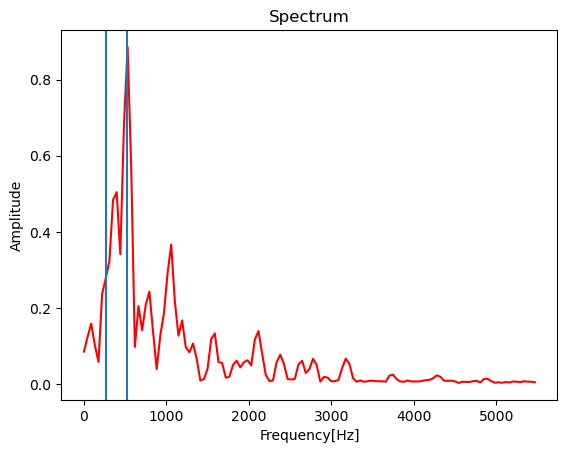

In [408]:
helper.plot_fft(sample_data[8], power_spectrum=True)
plt.axvline(262)
plt.axvline(522)

In [232]:
a = (-helper.stable_nlml(sample_time_samples, sample_data[7],normalised=False, f=score[2]))
b = (-helper.stable_nlml(sample_time_samples, sample_data[7],normalised=False, f=score[5]))
print(score[2],score[5])
probs = [a,b]
print(probs)
index = np.argmax(probs)
print(index)
print(probs[0])

[392] [392]
[-292437133059.6073, -292437133059.6073]
0
-292437133059.6073


In [ ]:
# Looking into making function to determine the octave

def 

In [109]:
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523]))
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523*2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523/2]))

3259.4427636762825
3252.2297267161425
3263.6486692849944
